# Final Project (Churn Prediction)
###### Estefania Perez & Daniel Cruz 

### 1. Data Preprocessing

In [1]:
#%pip install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  

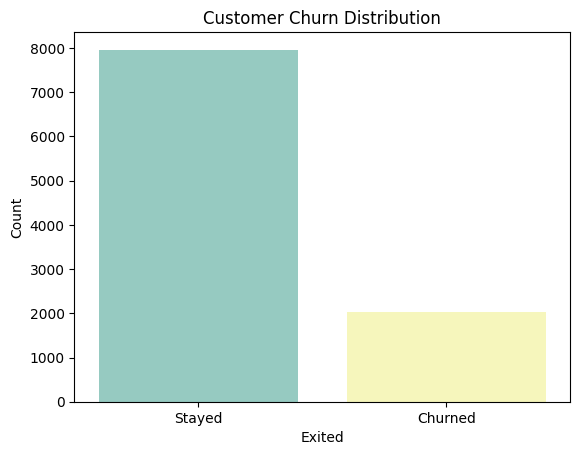

In [2]:
# EDA Summary of Churn_Modeling Dataset
churn_data = pd.read_csv('Churn_Modelling.csv')

print("Dataset Info:")
print(churn_data.info())
print("\n")

print("First 5 rows:")
print(churn_data.head())
print("\n")

print("Dataset Shape:")
print(f"{churn_data.shape[0]} rows, {churn_data.shape[1]} columns\n")

print("\n")
print(f"Chrun Percentage:\n {churn_data['Exited'].value_counts(normalize=True) * 100}")

sns.countplot(x='Exited', hue='Exited', data=churn_data, palette='Set3', legend=False)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.show()

In [3]:
'''
Cleaning/Preparing The Chrun Data
- Dropping Irrelevant Columns
- Encoding Categorical Variables
- Splitting into Train/Test Sets (80/20)
'''

#dropping irrelevant columns (RowNumber, CustomerId, Surname)
churn_data = churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#Encoding Categorical Variables (Gender (Binary Encoding) and Geography(One-hot encoding))
churn_data['Gender'] = churn_data['Gender'].map({'Female': 0, 'Male':1})
#Need to elaborate why we used get_dummies and drop_first
churn_data = pd.get_dummies(churn_data, columns = ['Geography'], drop_first=True)
print("Data is now Encoded Properly:")
print(churn_data.head())


#False, False = Francex
#True, False = Germany
#False, True = Spain

Data is now Encoded Properly:
   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


X_train shape: (8000, 11)
X_test shape: (2000, 11)

y_train distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
y_test distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


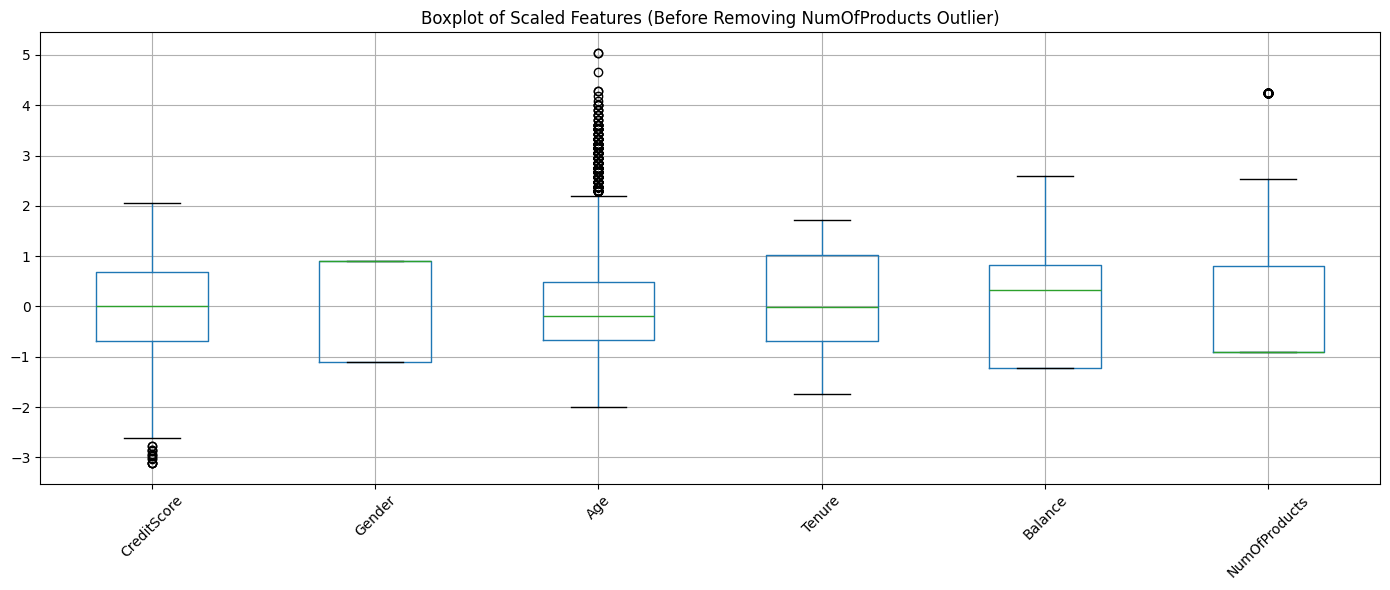


Removed 50 rows with NumOfProducts > 3
X_train shape after removal: (7950, 11)


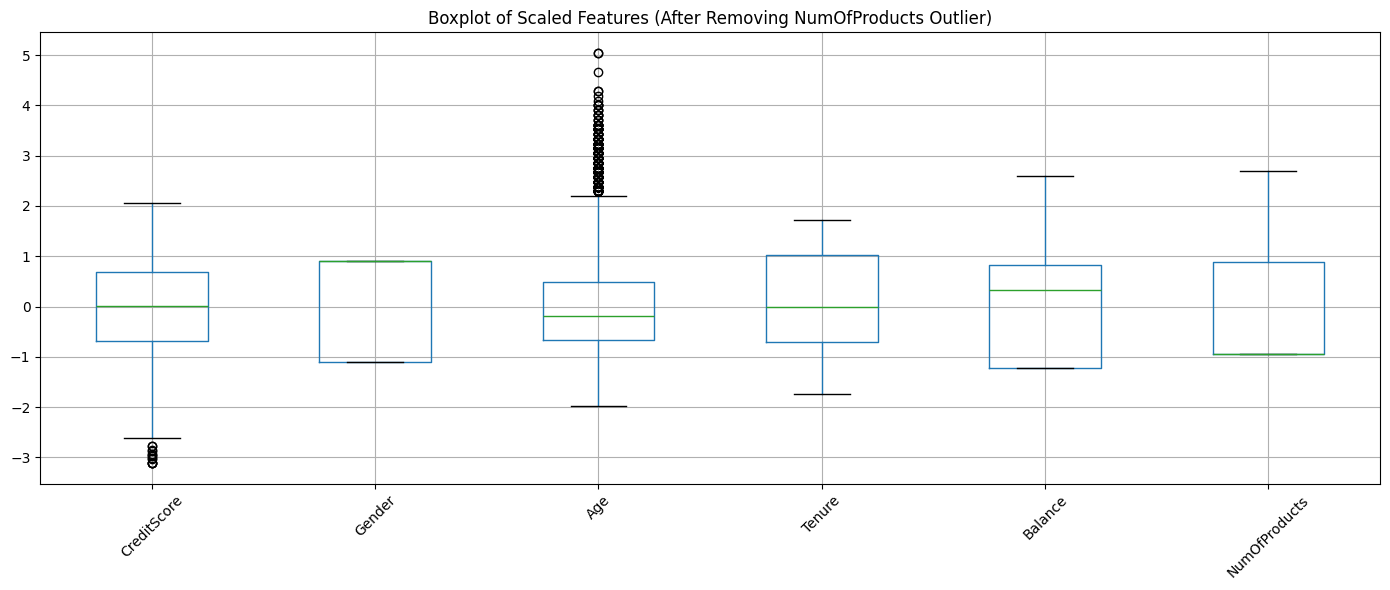


After SMOTE:
X_train_resampled shape: (12740, 11)
y_train_resampled distribution:
 Exited
1    0.5
0    0.5
Name: proportion, dtype: float64


In [4]:
# 1. Separate features and target
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

# 2. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

# 3. Scale original (before removing NumOfProducts outlier) for boxplot
scaler_before = StandardScaler()
X_train_scaled_before = scaler_before.fit_transform(X_train)
X_train_scaled_df_before = pd.DataFrame(X_train_scaled_before, columns=X_train.columns)

# 4. Boxplot BEFORE removing NumOfProducts > 3
plt.figure(figsize=(14, 6))
X_train_scaled_df_before.iloc[:, :6].boxplot()
plt.title("Boxplot of Scaled Features (Before Removing NumOfProducts Outlier)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Remove only NumOfProducts outlier
initial_rows = X_train.shape[0]
mask = X_train['NumOfProducts'] <= 3
X_train = X_train[mask]
y_train = y_train[mask]
removed_rows = initial_rows - X_train.shape[0]

print(f"\nRemoved {removed_rows} rows with NumOfProducts > 3")
print("X_train shape after removal:", X_train.shape)

# 6. Scale after removal for boxplot
scaler_after = StandardScaler()
X_train_scaled_after = scaler_after.fit_transform(X_train)
X_train_scaled_df_after = pd.DataFrame(X_train_scaled_after, columns=X_train.columns)

# 7. Boxplot AFTER removing NumOfProducts outlier
plt.figure(figsize=(14, 6))
X_train_scaled_df_after.iloc[:, :6].boxplot()
plt.title("Boxplot of Scaled Features (After Removing NumOfProducts Outlier)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled distribution:\n", y_train_resampled.value_counts(normalize=True))

### 2. Model Design and Training

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)  

X_train_scaled = scaler.transform(X_train)             
X_test_scaled = scaler.transform(X_test)               
X_train_resampled_scaled = scaler.transform(X_train_resampled)  

# Decision Tree
print("Decision Tree:")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_dt = dt_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("-" * 50)

# SVM 
print("Support Vector Machine (SVM):")
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("-" * 50)

# MLP 
print("MLP Classifier:")
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("-" * 50)

# Logistic Regression
print("Logistic Regression:")
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("-" * 50)


Decision Tree:
Accuracy: 0.7585
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1593
           1       0.43      0.59      0.50       407

    accuracy                           0.76      2000
   macro avg       0.66      0.70      0.67      2000
weighted avg       0.79      0.76      0.77      2000

--------------------------------------------------
Support Vector Machine (SVM):
Accuracy: 0.811
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1593
           1       0.53      0.65      0.58       407

    accuracy                           0.81      2000
   macro avg       0.72      0.75      0.73      2000
weighted avg       0.83      0.81      0.82      2000

--------------------------------------------------
MLP Classifier:
Accuracy: 0.827
Classification Report:
              precision    recall  f1-score   support

          

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [6]:
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use the cleaned, SMOTE-balanced training set
# X_train_resampled and y_train_resampled should come from earlier steps
# X_test is the original untouched test set

# ------------------- Bagging with Decision Tree -------------------
print("Bagging Classifier (with Decision Tree):")
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    n_estimators=10,
    random_state=42
)
bag_model.fit(X_train_resampled, y_train_resampled)
y_pred_bag = bag_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_bag):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bag))
print("-" * 50)

# ------------------- Random Forest -------------------
print("Random Forest Classifier:")
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("-" * 50)

# ------------------- XGBoost -------------------
print("XGBoost Classifier:")
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("-" * 50)


Bagging Classifier (with Decision Tree):
Accuracy: 0.8160
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1593
           1       0.54      0.60      0.57       407

    accuracy                           0.82      2000
   macro avg       0.72      0.74      0.73      2000
weighted avg       0.82      0.82      0.82      2000

--------------------------------------------------
Random Forest Classifier:
Accuracy: 0.8290
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.57      0.64      0.60       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000

--------------------------------------------------
XGBoost Classifier:
Accuracy: 0.8195
Classification Report:
              precision    recall  f1

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:13:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MLP Classifier:
Accuracy: 0.5175
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1593
           1       0.17      0.34      0.22       407

    accuracy                           0.52      2000
   macro avg       0.47      0.45      0.44      2000
weighted avg       0.65      0.52      0.56      2000

--------------------------------------------------


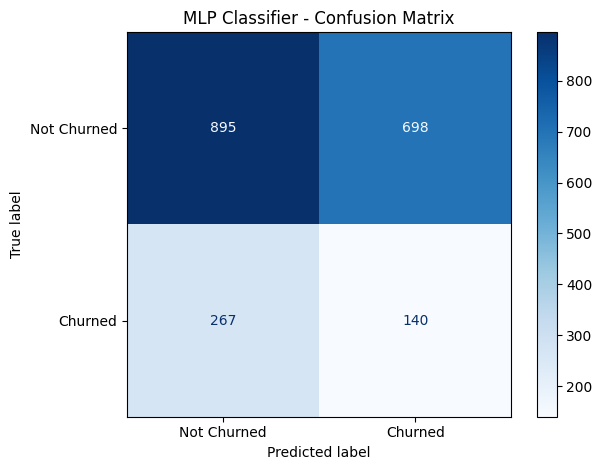

In [7]:
"""
After reviewing all of the classification algorithms it seems that MLP is the "best one" so we will be using
that model to train our dataset.
"""

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

print("MLP Classifier:")
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("-" * 50)

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    mlp_model, X_test, y_test,
    display_labels=["Not Churned", "Churned"],
    cmap=plt.cm.Blues,
    values_format='d'
)
plt.title("MLP Classifier - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

### 3. Model Improvements

#### Hyperparamter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#source that helped: https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(mlp_model, param_grid, n_jobs=-1, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

grid_pred = grid_search.predict(X_test)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Accuracy: ", accuracy_score(y_test, grid_pred))
print("Classification Report:")
print(classification_report(y_test, grid_pred))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#https://sklearner.com/scikit-learn-random-search-mlpclassifier/

param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100), (100, 50)],
              'activation': ['relu', 'tanh'],
              'solver': ['adam', 'sgd'],
              'alpha': [0.001, 0.01, 0.1],
              'learning_rate': ['constant', 'adaptive']}

random_search = RandomizedSearchCV(mlp_model, param_distributions=param_grid, n_iter=105, n_jobs=-1, cv=5, verbose=2)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
acc = best_model.score(X_test, y_test)
#print("Best hyperparameters: ", random_search.best_params_)
#print("Accuracy: " + str(acc))
#print("Classification Report:")
#print(classification_report(y_test, best_model.predict(X_test)))

with open('output.txt', 'w') as f: #output is more than 500 lines and wont show properly
    print("Best hyperparameters: ", random_search.best_params_, file=f)
    print("Accuracy: " + str(acc), file=f)
    print("Classification Report:", file=f)
    print(classification_report(y_test, best_model.predict(X_test)), file=f)

"""
Output from the file during the last run was:

Best hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.1, 'activation': 'tanh'}
Accuracy: 0.8695
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.51      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.77      2000
weighted avg       0.86      0.87      0.86      2000
"""

### Model Fusion

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Re-initialize models (with the same parameters you used before)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

# Train both models on resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Create soft voting ensemble
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # soft voting uses predicted probabilities
)

# Fit voting model on the same resampled training data
voting_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_voting = voting_model.predict(X_test)

# Evaluate
print("Soft Voting Classifier (Random Forest + XGBoost):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))



### Regularization Techniques:

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L2 Regularization (Ridge)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42, max_iter=1000)
log_reg_l2.fit(X_train, y_train)
y_pred_l2 = log_reg_l2.predict(X_test)

print("Logistic Regression with L2 Regularization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_l2)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_l2))